# Large-Scale SAE Analysis with UniProt Dataset

This notebook demonstrates how to analyze sparse autoencoders (SAEs) using a larger UniProt dataset,
following the InterPLM recommendations. We'll download Swiss-Prot data, create annotations, and mine SAE features.

In [63]:
from pathlib import Path
import pandas as pd, torch, os, gc
from interplm.sae.inference import load_sae_from_hf
import matplotlib.pyplot as plt
import numpy as np
DEVICE="cuda"

DATA_DIR = Path("esm_sae_results"); DATA_DIR.mkdir(exist_ok=True)
SEQUENCES_DIR = Path("/home/ec2-user/InterPLM/data/uniprot/subset_25k.csv")
# ANNOTATIONS_DIR = Path("uniprotkb_swissprot_annotations.tsv.gz")
ANNOTATIONS_DIR = Path("/home/ec2-user/InterPLM/subset_annotations.tsv.gz")



=== Sequence Statistics ===
count    40000.000000
mean       344.486825
std        184.688538
min         50.000000
25%        186.000000
50%        330.000000
75%        461.000000
max       1022.000000
Name: length, dtype: float64


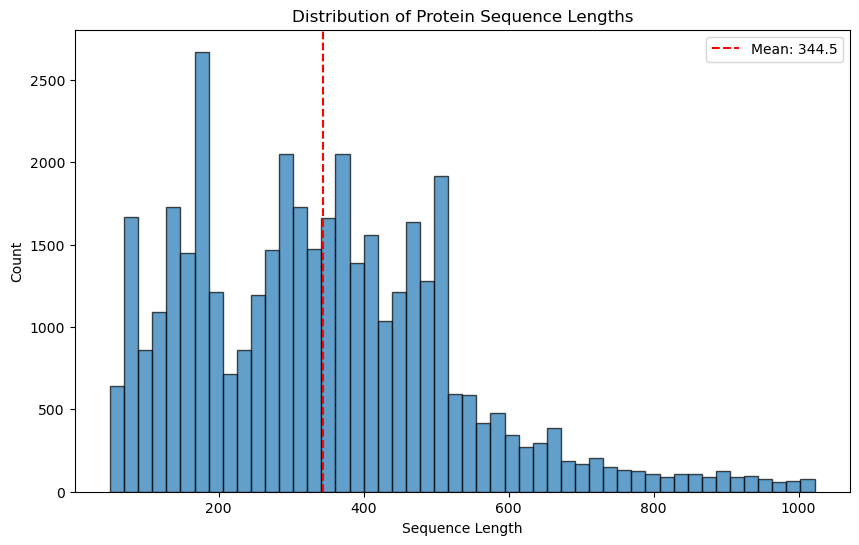

In [5]:
# Create larger subset for better analysis
sequences_df = pd.read_csv(SEQUENCES_DIR)

# Display basic statistics
print("\n=== Sequence Statistics ===")
print(sequences_df['length'].describe())

# Plot length distribution
plt.figure(figsize=(10, 6))
plt.hist(sequences_df['length'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Lengths')
plt.axvline(sequences_df['length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {sequences_df["length"].mean():.1f}')
plt.legend()
plt.show()

## 1. Setup and Imports

In [ ]:
from interplm.sae.inference import load_sae_from_hf

from transformers import AutoTokenizer, AutoModel
import torch
from typing import List, Literal, Tuple
@torch.no_grad()
def extract_sae_features(hidden_states: torch.Tensor, sae):
    """
    Pass ESM hidden states through the Sparse Autoencoder (SAE).

    Args
    ----
    hidden_states : torch.Tensor
        Shape [B, L, d] or [L, d].
        - B = batch size (optional if unsqueezed)
        - L = sequence length
        - d = ESM embedding dimension (e.g., 1280 for esm2_t33_650M)

    Returns
    -------
    sae_features : torch.Tensor
        Shape [B, L, F]
        Sparse latent features per residue.
        F = number of SAE dictionary atoms / features.

    recon : torch.Tensor
        Shape [B, L, d]
        Reconstructed embeddings in token space.

    error : torch.Tensor
        Shape [B, L, d]
        Residual = hidden_states - recon
    """
    if hidden_states.dim() == 2:          # [L, d]
        hidden_states = hidden_states.unsqueeze(0)  # → [1, L, d]
    x = hidden_states.to(torch.float32)      # <- ensure fp32 for SAE

    # SAE should have encode() and decode() that operate on last dimension
    sae_features = sae.encode(x)     # [B, L, F]
    recon        = sae.decode(sae_features)      # [B, L, d]
    error        = hidden_states - recon         # [B, L, d]

    return sae_features, recon, error

def pool_sequence_features(
    features: torch.Tensor,   # [B, L, F] or [L, F]
    method: str = "maX",
    mask: torch.Tensor = None # optional [B, L] attention mask
) -> torch.Tensor:
    """
    Pool per-residue features to per-sequence vectors.

    Args
    ----
    features : torch.Tensor
        Shape [B, L, F] (or [L, F] → will unsqueeze to batch 1).
        - B = batch size
        - L = sequence length
        - F = number of SAE features
    method : str
        "maX" → concatenate mean + max → [B, 2F]
        "mean"     → masked mean → [B, F]
        "max"      → masked max  → [B, F]
    mask : torch.Tensor, optional
        Shape [B, L] bool (True = valid residue, False = pad).
        If None, assumes all tokens are valid.

    Returns
    -------
    pooled : torch.Tensor
        Shape depends on method:
          - maX: [B, 2F]
          - mean or max: [B, F]
    """
    if features.dim() == 2:  # [L, F]
        features = features.unsqueeze(0)  # [1, L, F]

    B, L, F = features.shape
    if mask is None:
        mask = torch.ones(B, L, dtype=torch.bool, device=features.device)

    # apply mask
    mask_f = mask.float().unsqueeze(-1)  # [B, L, 1]
    feats_masked = features * mask_f

    if method == "mean":
        pooled = feats_masked.sum(1) / mask_f.sum(1).clamp_min(1e-8)
        return pooled  # [B, F]

    elif method == "max":
        very_neg = torch.finfo(features.dtype).min
        feats_masked = feats_masked.masked_fill(~mask.unsqueeze(-1), very_neg)
        return feats_masked.max(1).values  # [B, F]

    elif method == "maX":
        mean_pool = feats_masked.sum(1) / mask_f.sum(1).clamp_min(1e-8)  # [B, F]
        very_neg = torch.finfo(features.dtype).min
        feats_masked = feats_masked.masked_fill(~mask.unsqueeze(-1), very_neg)
        max_pool = feats_masked.max(1).values  # [B, F]
        return torch.cat([mean_pool, max_pool], dim=-1)  # [B, 2F]

    else:
        raise ValueError(f"Unknown pooling method: {method}")
        
@torch.no_grad()
def extract_esm_features_batch(
    sequences: List[str],
    layer_sel: int | Literal["last"] = "last",   # <— changed name/type
    device: torch.device = DEVICE,
    dtype = torch.float16,
    model = None,
    tokenizer = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    batch = tokenizer(sequences, return_tensors="pt", add_special_tokens=False, padding=True)
    batch = {k: v.to(device) for k, v in batch.items()}
    attn_mask = batch["attention_mask"].to(torch.bool)

    with torch.autocast(device_type="cuda", dtype=dtype):
        out = model(**batch, output_hidden_states=True, return_dict=True)
        hs = out.hidden_states  # tuple: [emb, layer1, ..., layerN] each [B,L,d]
        if layer_sel == "last":
            token_reps = hs[-1]
        elif isinstance(layer_sel, int):
            # ESM layers are 1-indexed in HF hidden_states after the embedding; adjust if you stored 0/1-based
            token_reps = hs[layer_sel]  # e.g., 24th encoder block reps
        else:
            raise ValueError(f"Invalid layer_sel: {layer_sel}")
    return token_reps, attn_mask


In [ ]:
import os, gc
from pathlib import Path
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


def _to_cpu_and_free(*tensors):
    out = []
    for t in tensors:
        if t is None:
            out.append(None)
            continue
        out.append(t.detach().to("cpu", non_blocking=True))
        del t
    torch.cuda.empty_cache()
    gc.collect()
    return out if len(out) > 1 else out[0]

def process_sequences_bucketed(
    sequences_df: pd.DataFrame,
    batch_size: int = 16,
    save_every: int = 1000,
    cache_name: str = "sae_features",
    desc: str = "processing",
    esm_layer_sel: int | Literal["last"] = "last",   # <— renamed
    model=None,
    sae=None,
    tokenizer=None,
    device: torch.device = DEVICE,
    amp_dtype = DTYPE,
) -> pd.DataFrame:
    model.eval()
    DATA_DIR.mkdir(exist_ok=True, parents=True)
    cache_dir = DATA_DIR / f"{cache_name}_cache"
    cache_dir.mkdir(exist_ok=True)

    df = sequences_df.copy()
    df["L"] = df["sequence"].str.len()
    df = df.sort_values("L").reset_index(drop=True)

    results, processed, next_save_threshold = [], 0, save_every
    pbar = tqdm(total=len(df), desc=desc, dynamic_ncols=True)

    cur_bs, i = batch_size, 0
    while i < len(df):
        window = df.iloc[i : min(i + cur_bs, len(df))]
        seqs = window["sequence"].tolist()
        ids  = window["uniprot_id"].tolist()

        try:
            with torch.no_grad(), torch.autocast(device_type="cuda", dtype=amp_dtype):
                token_reps, attn_mask = extract_esm_features_batch(
                    seqs, layer_sel=esm_layer_sel, device=device, dtype=amp_dtype,
                    model=model, tokenizer=tokenizer
                )
                sae_feats, recon, err = extract_sae_features(token_reps, sae)

                pooled = pool_sequence_features(sae_feats, mask=attn_mask, method="mean")  # [B,F]
                pooled, sae_feats, err = _to_cpu_and_free(pooled, sae_feats, err)

            for j, uid in enumerate(ids):
                results.append({
                    "uniprot_id": uid,
                    "length": int(len(seqs[j])),
                    "features": pooled[j].numpy(),                # [F]
                    "max_activation": sae_feats[j].amax().item(),
                    "n_active_features": (sae_feats[j] > 0.1).sum().item(),
                    "reconstruction_mse": err[j].pow(2).mean().item(),
                })

            processed += len(window); pbar.update(len(window)); i += len(window)
            if processed >= next_save_threshold or processed == len(df):
                cache_file = cache_dir / f"{cache_name}_{processed}.pkl"
                pd.DataFrame(results).to_pickle(cache_file)
                print(f"[checkpoint] saved {processed} → {cache_file}")
                next_save_threshold += save_every

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache(); gc.collect()
                if cur_bs > 1:
                    cur_bs = max(1, cur_bs // 2)
                    print(f"[OOM] reducing batch_size → {cur_bs} and retrying")
                    continue
                else:
                    print(f"[OOM] Skipping {ids[0]} (len={len(seqs[0])})")
                    i += 1; pbar.update(1); continue
            else:
                print(f"[ERROR] {ids[0]}: {e}")
                i += 1; pbar.update(1); continue

    pbar.close()
    out_df = pd.DataFrame(results)
    out_path = DATA_DIR / f"{cache_name}.pkl"
    out_df.to_pickle(out_path)
    print(f"[done] {len(out_df)} sequences → {out_path}")
    return out_df


## Parallel processing

In [ ]:
import ray, os, pandas as pd, torch
from pathlib import Path
from interplm.sae.inference import load_sae_from_hf
from transformers import AutoTokenizer, AutoModel

ray.shutdown()
ray.init(ignore_reinit_error=True, num_gpus=8)

DATA_DIR = Path("esm_sae_results"); DATA_DIR.mkdir(exist_ok=True)
sequences_df.to_pickle(DATA_DIR / "sequences_df.pkl")

@ray.remote(num_gpus=1)
def ray_worker(rank: int, world_size: int, input_path: str, out_name: str,
               batch_size: int = 16, save_every: int = 1000,
               esm_layer_sel: int | Literal["last"] = 24):
    os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")

    # Each Ray task sees 1 GPU as cuda:0
    DEVICE = torch.device("cuda:0")
    DTYPE  = torch.float16

    # Load ESM and SAE inside the worker
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", do_lower_case=False)
    model     = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D",
                                          output_hidden_states=True).to(DEVICE).eval()

    # Make sure the SAE you load matches the *plm_model* and *plm_layer* you want to use
    plm_model = "esm2-650m"   # matches your checkpoint naming
    plm_layer = 24            # <= MUST match esm_layer_sel
    sae = load_sae_from_hf(plm_model=plm_model, plm_layer=plm_layer).to(DEVICE).eval()

    df = pd.read_pickle(input_path)
    shard = df.iloc[rank::world_size].reset_index(drop=True)

    cache_name = f"{out_name}_rank{rank}"
    out_df = process_sequences_bucketed(
        sequences_df=shard,
        batch_size=batch_size,
        save_every=save_every,
        cache_name=cache_name,
        desc=f"rank{rank}",
        esm_layer_sel=esm_layer_sel,
        model=model,
        sae=sae,
        tokenizer=tokenizer,
        device=DEVICE,
        amp_dtype=DTYPE,
    )

    out_path = DATA_DIR / f"{cache_name}.final.pkl"
    out_df.to_pickle(out_path)
    return str(out_path)


In [ ]:
WORLD_SIZE = 8
input_path = str(DATA_DIR / "sequences_df.pkl")
futs = [ray_worker.remote(r, WORLD_SIZE, input_path, "sae_features") for r in range(WORLD_SIZE)]
paths = ray.get(futs)
paths

In [82]:
import glob
parts = [pd.read_pickle(p) for p in sorted(glob.glob(str(DATA_DIR / "sae_features_rank*.final.pkl")))]
features_all = pd.concat(parts, ignore_index=True).drop_duplicates(subset=["uniprot_id"])
features_all.to_pickle(DATA_DIR / "sae_features_all.pkl")
features_all.shape


(40000, 6)

In [83]:
features_all.head()

,uniprot_id,length,features,max_activation,n_active_features,reconstruction_mse
0,Q9GL23,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...",1.265625,1876,45.198380
1,Q6GZU6,50,"[0.00023197175, 0.0, 0.0, 0.0, 0.0013056946, 0...",0.843262,2168,13.467114
2,P9WJG6,50,"[0.0, 0.00057144166, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.935059,1740,12.720748
3,P18924,51,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",0.956543,1799,11.394856
4,Q08076,52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1.139648,1772,24.694654


In [6]:
features_all.to_csv("features.csv")

NameError: name 'features_all' is not defined

In [11]:
features_all.head(10)

,uniprot_id,length,features,max_activation,n_active_features,reconstruction_mse
0,Q9GL23,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002...",1.265625,1876,45.198380
1,Q6GZU6,50,"[0.00023197175, 0.0, 0.0, 0.0, 0.0013056946, 0...",0.843262,2168,13.467114
2,P9WJG6,50,"[0.0, 0.00057144166, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.935059,1740,12.720748
3,P18924,51,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",0.956543,1799,11.394856
4,Q08076,52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1.139648,1772,24.694654
5,P15450,53,"[0.0, 0.00019778845, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.090820,1698,13.188174
6,P40643,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031...",0.881348,1450,21.303719
7,P12697,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...",1.243164,1535,21.009787
8,O78683,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",1.144531,1657,20.722115
9,Q9MJC0,54,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001...",1.224609,1680,25.309597


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Quick peek at the annotation file ---
annotations_path = Path(ANNOTATIONS_DIR)  # update with your path
df = pd.read_csv(annotations_path, sep="\t", compression="gzip")
print("Columns in UniProt annotations:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head(3).T)  # transpose to make it easier to read

Columns in UniProt annotations:
['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number', 'Active site', 'Binding site', 'Cofactor', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide', 'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil', 'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Zinc finger']

First few rows:
                                                                    0  \
Entry                                                      A0A009IHW8   
Reviewed                                                     reviewed   
Protein names       2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...   
Length                                                            269   
Sequence            MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...   
EC number                                            3.2.2.-; 3.2.2.6   
Active site         ACT_SITE 208; /evidence="ECO:0000255|PROSITE-P...   
Binding sit

In [10]:
# --- 2. Pick a few IDs you processed ---
features_all = pd.read_csv("features.csv")
print("\nExample UniProt IDs in your features_all:")
print(features_all['uniprot_id'].head().tolist())

# --- 3. Check if those IDs exist in the annotations ---
ids_to_check = features_all['uniprot_id'].head(5).tolist()
sub = pd.read_csv(annotations_path, sep="\t", compression="gzip")
print(sub.shape)
sub = sub[sub['Entry'].isin(ids_to_check)]
print(sub.shape)
print(f"\nFound {len(sub)} matches in annotations:")
print(sub[['Entry','Protein names','Length']].head())


Example UniProt IDs in your features_df:
['Q9GL23', 'Q6GZU6', 'P9WJG6', 'P18924', 'Q08076']
(573661, 25)
(5, 25)

Found 5 matches in annotations:
         Entry                                      Protein names  Length
222838  Q08076  ATP synthase protein 8 (A6L) (F-ATPase subunit 8)      52
425062  P18924                       Uncharacterized protein 52.2      51
441576  P9WJG6              Uncharacterized membrane protein ArfB      50
531041  Q9GL23    Apoptotic protease-activating factor 1 (APAF-1)      50
567402  Q6GZU6                       Uncharacterized protein 030R      50


In [18]:
# import requests
# from pathlib import Path
# from tqdm import tqdm

# fields = (
#     "accession,reviewed,protein_name,length,sequence,"
#     "ec,ft_act_site,ft_binding,cc_cofactor,ft_disulfid,"
#     "ft_carbohyd,ft_lipid,ft_mod_res,ft_signal,ft_transit,"
#     "ft_helix,ft_turn,ft_strand,ft_coiled,cc_domain,"
#     "ft_compbias,ft_domain,ft_motif,ft_region,ft_zn_fing"
# )
# url = (
#     "https://rest.uniprot.org/uniprotkb/stream"
#     f"?format=tsv&compressed=true&fields={fields}"
#     "&query=(reviewed:true)"
# )

# out = Path("uniprotkb_swissprot_annotations.tsv.gz")
# print("Downloading Swiss-Prot annotations…")

# # stream in chunks
# with requests.get(url, stream=True) as r:
#     r.raise_for_status()
#     total_size = int(r.headers.get("Content-Length", 0))
#     chunk_size = 1024 * 1024  # 1 MB
#     with open(out, "wb") as f, tqdm(
#         total=total_size, unit="B", unit_scale=True, desc="Downloading"
#     ) as pbar:
#         for chunk in r.iter_content(chunk_size=chunk_size):
#             f.write(chunk)
#             pbar.update(len(chunk))

# print("Saved:", out)


Downloading: 197MB [02:49, 1.16MB/s] 

Saved: uniprotkb_swissprot_annotations.tsv.gz


## 6. Create Rich Protein Annotations

Extract and process UniProt annotations to create binary concept labels.

Loading annotations from /home/ec2-user/InterPLM/subset_annotations.tsv.gz...
Index(['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number',
       'Active site', 'Binding site', 'Cofactor', 'Disulfide bond',
       'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide',
       'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil',
       'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region',
       'Zinc finger'],
      dtype='object')
Loaded 40000 protein annotations
\nFiltering annotations to match processed sequences...
After filtering: 40000 annotations remain
Available columns: ['Entry', 'Reviewed', 'Protein names', 'Length', 'Sequence', 'EC number', 'Active site', 'Binding site', 'Cofactor', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue', 'Signal peptide', 'Transit peptide', 'Helix', 'Turn', 'Beta strand', 'Coiled coil', 'Domain [CC]', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Zinc finge

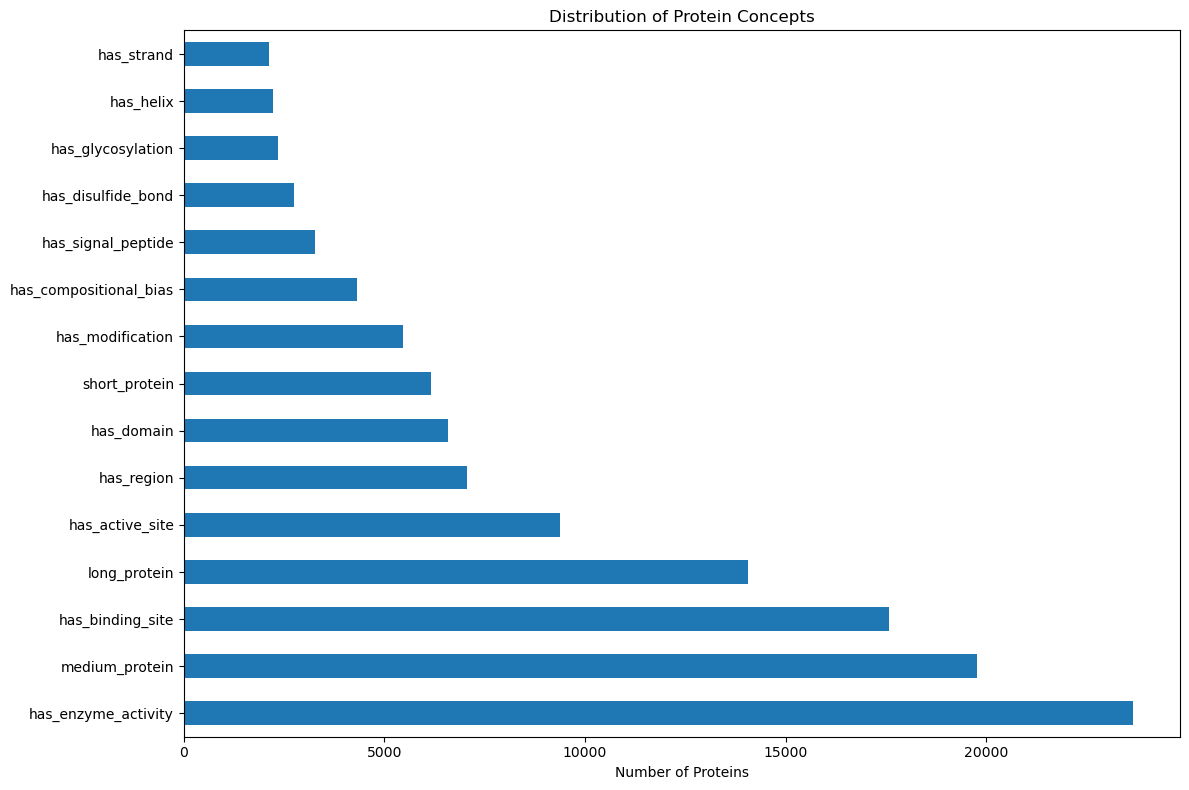

In [69]:
def parse_uniprot_annotations(annotations_path: Path):
    """
    Parse UniProt annotations and create binary concept labels.
    """
    print(f"Loading annotations from {annotations_path}...")
    
    # Read the TSV file
    annotations_df = pd.read_csv(annotations_path, sep='\t', compression='gzip')
    print(annotations_df.columns)
    print(f"Loaded {len(annotations_df)} protein annotations")

    # Filter annotations to match our sequence subset
    print(f"\\nFiltering annotations to match processed sequences...")
    processed_ids = set(sequences_df['uniprot_id'])
    annotations_df = annotations_df[annotations_df['Entry'].isin(processed_ids)]

    print(f"After filtering: {len(annotations_df)} annotations remain")
    print(f"Available columns: {list(annotations_df.columns)}")
    if len(annotations_df) == 0:
        print("ERROR: No matching annotations found!")
        print("This suggests the UniProt IDs don't match between FASTA and annotations.")
        print("Checking a few examples...")
        print(f"FASTA IDs (first 5): {list(sequences_df['uniprot_id'].head())}")
        # Try loading a few annotation entries to see format
        temp_df = pd.read_csv(annotations_path, sep='\\t', compression='gzip', nrows=5)
        print(f"Annotation IDs (first 5): {list(temp_df['Entry'])}")
        return None, None
    
    # Create binary concept labels
    concepts = {}
    
    # Structural features
    concepts['Entry'] = annotations_df['Entry']
    concepts['has_signal_peptide'] = ~annotations_df['Signal peptide'].isna()
    concepts['has_disulfide_bond'] = ~annotations_df['Disulfide bond'].isna()
    concepts['has_helix'] = ~annotations_df['Helix'].isna()
    concepts['has_strand'] = ~annotations_df['Beta strand'].isna()
    concepts['has_turn'] = ~annotations_df['Turn'].isna()
    concepts['has_coiled_coil'] = ~annotations_df['Coiled coil'].isna()
    
    # Post-translational modifications
    concepts['has_glycosylation'] = ~annotations_df['Glycosylation'].isna()
    concepts['has_lipidation'] = ~annotations_df['Lipidation'].isna()
    concepts['has_modification'] = ~annotations_df['Modified residue'].isna()
    
    # Functional features
    concepts['has_active_site'] = ~annotations_df['Active site'].isna()
    concepts['has_binding_site'] = ~annotations_df['Binding site'].isna()
    concepts['has_enzyme_activity'] = ~annotations_df['EC number'].isna()
    
    # Sequence features
    concepts['has_domain'] = ~annotations_df['Domain [FT]'].isna()
    concepts['has_motif'] = ~annotations_df['Motif'].isna()
    concepts['has_region'] = ~annotations_df['Region'].isna()
    concepts['has_zinc_finger'] = ~annotations_df['Zinc finger'].isna()
    concepts['has_compositional_bias'] = ~annotations_df['Compositional bias'].isna()
    
    # Length-based categories
    concepts['short_protein'] = annotations_df['Length'] < 150
    concepts['medium_protein'] = (annotations_df['Length'] >= 150) & (annotations_df['Length'] < 400)
    concepts['long_protein'] = annotations_df['Length'] >= 400
    print("before pd")
    # Convert to DataFrame
    concepts_df = pd.DataFrame(concepts)
    # Add sequence information
    concepts_df['sequence'] = annotations_df['Sequence'].values
    concepts_df['length'] = annotations_df['Length'].values
    concepts_df['protein_name'] = annotations_df['Protein names'].values
    
    return concepts_df, annotations_df

# Parse annotations
concepts_df, raw_annotations = parse_uniprot_annotations(ANNOTATIONS_DIR)

if concepts_df is not None:
    print(f"\\nCreated {len(concepts_df)} concept annotations")
    print(f"Available concepts: {[col for col in concepts_df.columns if col not in ['sequence', 'length', 'protein_name']]}")
    
    # Show concept statistics
    concept_cols = [col for col in concepts_df.columns if col not in ['Entry', 'sequence', 'length', 'protein_name']]
    concept_stats = concepts_df[concept_cols].sum().sort_values(ascending=False)
    
    print("\\n=== Concept Statistics ===")
    for concept, count in concept_stats.head(15).items():
        pct = 100 * count / len(concepts_df)
        print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")
    
    # Visualize concept distribution
    plt.figure(figsize=(12, 8))
    concept_stats.head(15).plot(kind='barh')
    plt.xlabel('Number of Proteins')
    plt.title('Distribution of Protein Concepts')
    plt.tight_layout()
    plt.show()
else:
    print("Failed to parse annotations - please check the data sources.")

In [75]:
concepts_df
concepts_df = concepts_df.set_index('Entry')

## 7. Match Features with Annotations

Align the extracted SAE features with the protein annotations for analysis.

In [84]:
# Match features with concepts by UniProt ID
feature_ids = set(features_all['uniprot_id'])
concept_ids = set(concepts_df.index)
common_ids = feature_ids.intersection(concept_ids)

print(f"Features extracted for: {len(feature_ids)} proteins")
print(f"Concepts available for: {len(concept_ids)} proteins")
print(f"Common proteins: {len(common_ids)} proteins")

Features extracted for: 40000 proteins
Concepts available for: 40000 proteins
Common proteins: 40000 proteins


In [85]:

if len(common_ids) < 500:
    print("\nWarning: Overlap between features and concepts could be higher.")
    print(f"Current overlap: {len(common_ids)} proteins")
    if len(common_ids) < 100:
        print("Very low overlap - this might limit analysis quality.")
else:
    print(f"\nGood overlap: {len(common_ids)} proteins for analysis")

# Create matched dataset (convert set to list for pandas indexing)
matched_features = features_all[features_all['uniprot_id'].isin(common_ids)]

matched_features = features_all[features_all['uniprot_id'].isin(common_ids)].set_index('uniprot_id')


matched_concepts = concepts_df.loc[list(common_ids)]

# Align the data
aligned_data = matched_features.join(matched_concepts, how='inner',  lsuffix='_feat', rsuffix='_ann')

print(f"\nAligned dataset: {len(aligned_data)} proteins")



Good overlap: 40000 proteins for analysis

Aligned dataset: 40000 proteins


In [87]:
aligned_data.iloc[0]['features'].shape
# print(f"Feature dimension: {aligned_data['features'].iloc[0].shape[0]}")

(10240,)

In [67]:
first_features = aligned_data.iloc[0]['features']
first_features


array([0., 0., 0.])

In [88]:

# Create feature matrix
X = np.vstack(aligned_data['features'].values)
print(X.shape[1])


10240


In [93]:
print(f"Feature matrix shape: {X.shape}")

# Get concept labels
concept_cols = [col for col in aligned_data.columns 
                if col not in ['features', 'length_feat', 'length_ann', 'max_activation', 'n_active_features', 
                               'reconstruction_mse', 'sequence', 'protein_name']]
Y = aligned_data[concept_cols].astype(int)

print(f"\nConcept matrix shape: {Y.shape}")
print(f"Available concepts for analysis: {len(concept_cols)}")

# Show concept statistics for the aligned dataset
print("\n=== Concept Statistics (Aligned Data) ===")
concept_stats_aligned = Y.sum().sort_values(ascending=False)
for concept, count in concept_stats_aligned.head(15).items():
    pct = 100 * count / len(Y)
    print(f"{concept:25s}: {count:5d} ({pct:5.1f}%)")

Feature matrix shape: (40000, 10240)

Concept matrix shape: (40000, 20)
Available concepts for analysis: 20

=== Concept Statistics (Aligned Data) ===
has_enzyme_activity      : 23644 ( 59.1%)
medium_protein           : 19758 ( 49.4%)
has_binding_site         : 17583 ( 44.0%)
long_protein             : 14072 ( 35.2%)
has_active_site          :  9371 ( 23.4%)
has_region               :  7058 ( 17.6%)
has_domain               :  6581 ( 16.5%)
short_protein            :  6170 ( 15.4%)
has_modification         :  5471 ( 13.7%)
has_compositional_bias   :  4323 ( 10.8%)
has_signal_peptide       :  3271 (  8.2%)
has_disulfide_bond       :  2755 (  6.9%)
has_glycosylation        :  2335 (  5.8%)
has_helix                :  2231 (  5.6%)
has_strand               :  2133 (  5.3%)


## 8. SAE Feature Mining and Analysis

Analyze which SAE features are associated with different protein concepts.

In [94]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

## Grab association

In [115]:
def compute_feature_concept_associations(X_features: np.ndarray, Y_concepts:pd.DataFrame, min_concept_instances: int=5):
    """
    Compute associations between SAE features and protein concepts using AUC.

    Args:
        X_features: numpy array of shape (n_samples, n_features)
        Y_concepts: dataframe of shape (n_samples, n_concepts) with binary values
        min_concept_instances: skip concepts with fewer positives/negatives than this
    """

    results = {}
    n_features = X_features.shape[1]

    print(f"Computing associations for {n_features} features and {len(Y_concepts.columns)} concepts ...")

    #Loop through each concept column

    for concept in Y_concepts.columns:
        y = Y_concepts[concept].values #binary labels (0/1)

        #Skip if too few positive/negative samples
        if y.sum() < min_concept_instances or (len(y) - y.sum()) < min_concept_instances:
            print(f"  Skipping {concept}: only {y.sum()}/{len(y)} positives")
            continue
        print(f"  Processing {concept}: {y.sum()}/{len(y)} positives")

        aucs = []
        for feature_idx in range(n_features):
            #also the features are mean pooled to get it for each sequence: what is the point of per residue features? i feel like the labels don't necessarily apply...
            feature_values = X_features[:, feature_idx]

            #Skip non-informative features
            if len(np.unique(feature_values))< 2:
                aucs.append(0.5) # baseline AUC
                continue

            try:
                auc = roc_auc_score(y, feature_values)
                aucs.append(auc)
            except ValueError:
                print("value error")
                aucs.append(0.5)
        
        #convert to numpy arra for ranking
        aucs = np.array(aucs)

        #ranking features by distance from random (0.5)
        
        #np.argsort of how far each auc is from the random baseline. 

        #[::-1] means start: nothing = whole array, stop: nothing default = end, step: -1 (go backwards)
        #Since np.argsort is smallest to largest. Then grabs the first 20.
        top_indices = np.argsort(np.abs(aucs - 0.5))[::-1][:20]

        results[concept] = {
        "aucs": aucs,
        "top_features": [(int(idx), aucs[idx]) for idx in top_indices],
        "n_positive": int(y.sum()),
        "n_total": len(y),
        }

    return results



In [116]:
print(X.shape) # should be (N_proteins, feature_dim) = (40k, 10240)
print(Y.shape) # Should be (n_proteins, n_concepts) = (40k, 20)

(40000, 10240)
(40000, 20)


In [117]:
if concepts_df is not None and len(aligned_data) > 0:
    associations = compute_feature_concept_associations(X, Y, min_concept_instances=10)
    print("\n=== Feature-Concept Associations ===")
    print(f"Analyzed {len(associations)} concepts")

    for concept, data in associations.items():
        top_features = data["top_features"][:5]
        print(f"\n{concept} ({data['n_positive']}/{data['n_total']} examples):")
        for feature_idx, auc in top_features:
            print(f"  Feature {feature_idx:4d}: AUC = {auc:.3f}")
else:
    print("Cannot compute associations - missing concept data or aligned dataset.")


Computing associations for 10240 features and 20 concepts ...
  Processing has_signal_peptide: 3271/40000 positives


In [113]:
asc = associations

## 9. Visualize Feature Patterns

Create visualizations to understand what the SAE features have learned.

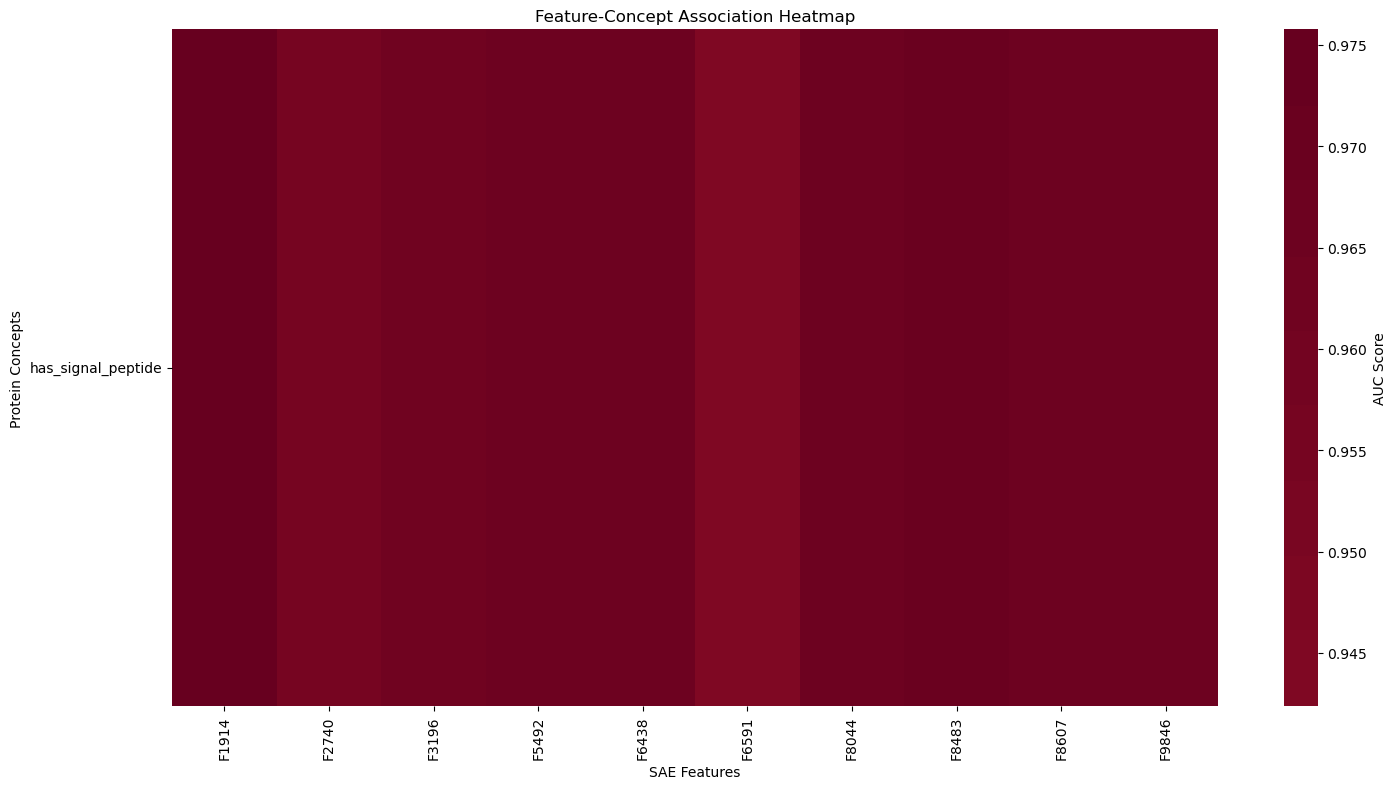

\n=== Feature Distribution Examples ===
\nPlotting Feature 1914 vs has_signal_peptide (AUC = 0.976)


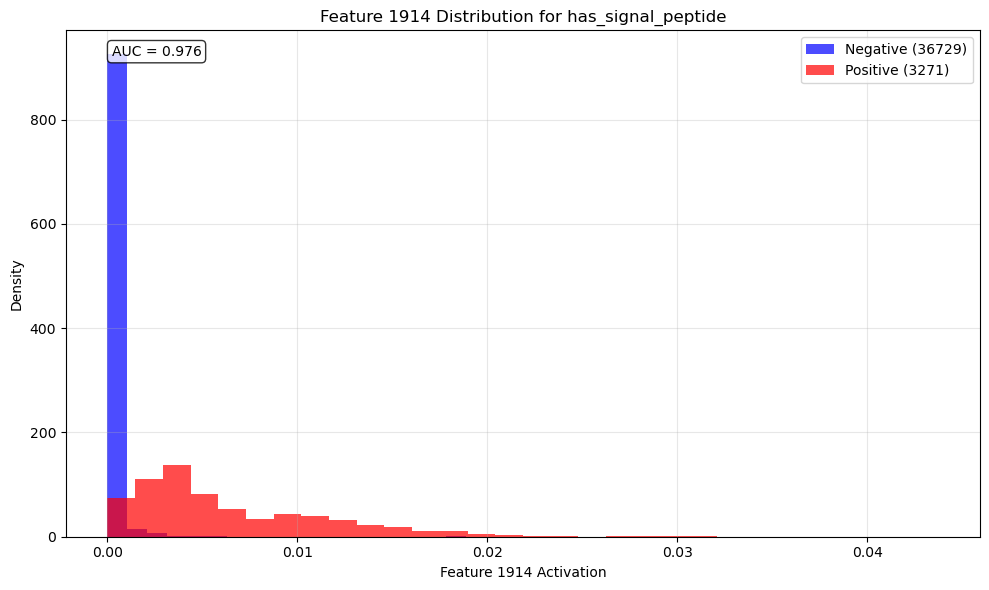

\nPlotting Feature 8483 vs has_signal_peptide (AUC = 0.970)


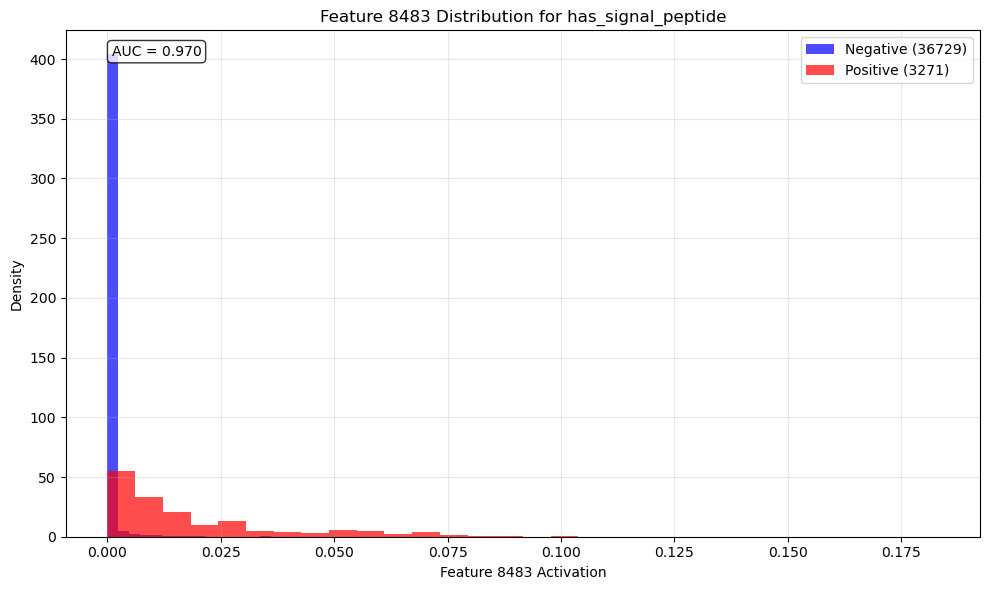

\nPlotting Feature 9846 vs has_signal_peptide (AUC = 0.968)


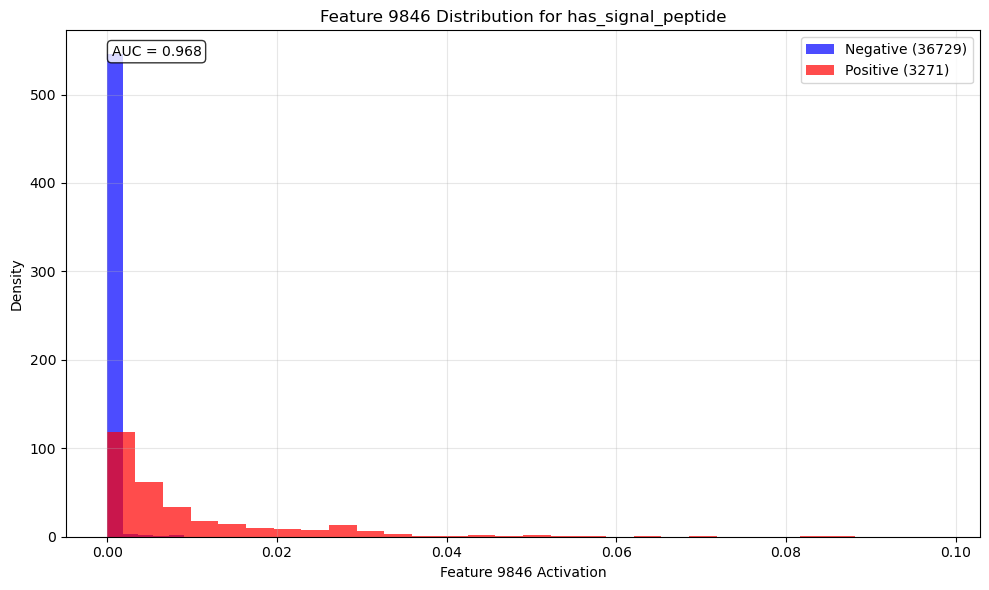

In [111]:
import seaborn as sns
def plot_top_features_heatmap(associations: dict, X_features: np.ndarray, Y_concepts: pd.DataFrame):
    """
    Create a heatmap showing the top features for each concept.
    """
    # Collect top features across all concepts
    all_top_features = set()
    for concept_data in associations.values():
        top_features = [f[0] for f in concept_data['top_features'][:10]]
        all_top_features.update(top_features)
    
    all_top_features = sorted(list(all_top_features))
    
    # Create AUC matrix
    auc_matrix = np.zeros((len(associations), len(all_top_features)))
    concept_names = list(associations.keys())
    
    for i, concept in enumerate(concept_names):
        aucs = associations[concept]['aucs']
        for j, feature_idx in enumerate(all_top_features):
            auc_matrix[i, j] = aucs[feature_idx]
    
    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(auc_matrix, 
                xticklabels=[f"F{f}" for f in all_top_features],
                yticklabels=concept_names,
                cmap='RdBu_r', center=0.5, 
                cbar_kws={'label': 'AUC Score'})
    plt.title('Feature-Concept Association Heatmap')
    plt.xlabel('SAE Features')
    plt.ylabel('Protein Concepts')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return auc_matrix, concept_names, all_top_features

def plot_feature_distributions(feature_idx: int, concept: str, 
                              X_features: np.ndarray, Y_concepts: pd.DataFrame):
    """
    Plot the distribution of a specific feature for positive vs negative examples of a concept.
    """
    y = Y_concepts[concept].values
    feature_values = X_features[:, feature_idx]
    
    plt.figure(figsize=(10, 6))
    
    # Plot distributions
    plt.hist(feature_values[y == 0], bins=30, alpha=0.7, label=f'Negative ({(y==0).sum()})', 
             density=True, color='blue')
    plt.hist(feature_values[y == 1], bins=30, alpha=0.7, label=f'Positive ({(y==1).sum()})', 
             density=True, color='red')
    
    plt.xlabel(f'Feature {feature_idx} Activation')
    plt.ylabel('Density')
    plt.title(f'Feature {feature_idx} Distribution for {concept}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add AUC score
    auc = roc_auc_score(y, feature_values)
    plt.text(0.05, 0.95, f'AUC = {auc:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Only create visualizations if we have associations
if 'associations' in locals() and len(associations) > 0:
    # Create heatmap
    auc_matrix, concept_names, top_features = plot_top_features_heatmap(associations, X, Y)
    
    # Plot distributions for a few interesting feature-concept pairs
    print("\\n=== Feature Distribution Examples ===")
    
    # Find the most discriminative feature-concept pairs
    best_pairs = []
    for i, concept in enumerate(concept_names):
        for j, feature_idx in enumerate(top_features):
            auc = auc_matrix[i, j]
            if abs(auc - 0.5) > 0.2:  # Strong association (lowered threshold)
                best_pairs.append((feature_idx, concept, auc))
    
    best_pairs.sort(key=lambda x: abs(x[2] - 0.5), reverse=True)
    
    # Plot top 3 most discriminative pairs
    if len(best_pairs) > 0:
        for feature_idx, concept, auc in best_pairs[:3]:
            print(f"\\nPlotting Feature {feature_idx} vs {concept} (AUC = {auc:.3f})")
            plot_feature_distributions(feature_idx, concept, X, Y)
    else:
        print("No strongly discriminative feature-concept pairs found (AUC deviation > 0.2)")
else:
    print("Skipping visualizations - no associations computed.")

## 10. Sequence-Level Analysis

Examine individual sequences to understand how features activate across protein regions.

In [112]:
def analyze_sequence_features(uniprot_id: str, top_k_features: int = 5):
    """
    Analyze feature activations for a specific protein sequence.
    """
    # Get sequence data
    seq_data = aligned_data.loc[uniprot_id]
    sequence = seq_data['sequence']
    
    print(f"\n=== Analysis for {uniprot_id} ===")
    print(f"Protein name: {seq_data['protein_name']}")
    print(f"Length: {len(sequence)} residues")
    
    # Show active concepts
    active_concepts = [col for col in concept_cols if seq_data[col] == 1]
    print(f"Active concepts: {', '.join(active_concepts) if active_concepts else 'None'}")
    
    # Extract per-residue features
    hidden_states = extract_esm_features(sequence)
    sae_features, _, _ = extract_sae_features(hidden_states)
    
    # Find top-activating features
    mean_activations = sae_features.mean(0)
    top_features_idx = torch.topk(mean_activations, top_k_features).indices
    
    print(f"\nTop {top_k_features} features by mean activation:")
    for i, feature_idx in enumerate(top_features_idx):
        mean_act = mean_activations[feature_idx].item()
        max_act = sae_features[:, feature_idx].max().item()
        print(f"  {i+1}. Feature {feature_idx:4d}: mean={mean_act:.3f}, max={max_act:.3f}")
    
    # Plot feature activations along sequence
    fig, axes = plt.subplots(top_k_features, 1, figsize=(12, 2*top_k_features))
    if top_k_features == 1:
        axes = [axes]
    
    for i, feature_idx in enumerate(top_features_idx):
        activations = sae_features[:, feature_idx].cpu().numpy()
        
        axes[i].plot(activations, linewidth=2)
        axes[i].set_ylabel(f'Feature {feature_idx}')
        axes[i].set_title(f'Feature {feature_idx} Activation (mean={mean_activations[feature_idx]:.3f})')
        axes[i].grid(True, alpha=0.3)
        
        # Highlight high-activation regions
        threshold = activations.mean() + 2 * activations.std()
        high_regions = activations > threshold
        if high_regions.any():
            axes[i].fill_between(range(len(activations)), 0, activations, 
                               where=high_regions, alpha=0.3, color='red')
    
    axes[-1].set_xlabel('Residue Position')
    plt.suptitle(f'SAE Feature Activations: {uniprot_id}')
    plt.tight_layout()
    plt.show()
    
    return sae_features, top_features_idx

# Analyze a few interesting examples
print("=== Sequence-Level Feature Analysis ===")

# Find some proteins with different concept patterns
examples = []

# Get an example with signal peptide
if 'has_signal_peptide' in Y.columns:
    signal_proteins = Y[Y['has_signal_peptide'] == 1].index
    if len(signal_proteins) > 0:
        examples.append(signal_proteins[0])

# Get an example with enzyme activity
if 'has_enzyme_activity' in Y.columns:
    enzyme_proteins = Y[Y['has_enzyme_activity'] == 1].index
    if len(enzyme_proteins) > 0:
        examples.append(enzyme_proteins[0])

# Get a structural protein example
if 'has_domain' in Y.columns:
    domain_proteins = Y[Y['has_domain'] == 1].index
    if len(domain_proteins) > 0:
        examples.append(domain_proteins[0])

# Remove duplicates and limit to 3 examples
examples = list(set(examples))[:3]

for example_id in examples:
    try:
        analyze_sequence_features(example_id)
    except Exception as e:
        print(f"Error analyzing {example_id}: {e}")

=== Sequence-Level Feature Analysis ===

=== Analysis for P15450 ===
Protein name: Abaecin
Length: 53 residues
Active concepts: has_signal_peptide, short_protein
Error analyzing P15450: name 'extract_esm_features' is not defined

=== Analysis for Q9GL23 ===
Protein name: Apoptotic protease-activating factor 1 (APAF-1)
Length: 50 residues
Active concepts: has_domain, short_protein
Error analyzing Q9GL23: name 'extract_esm_features' is not defined

=== Analysis for P20699 ===
Protein name: Isocitrate lyase (ICL) (EC 4.1.3.1) (Isocitrase) (Isocitratsysase)
Length: 58 residues
Active concepts: has_enzyme_activity, short_protein
Error analyzing P20699: name 'extract_esm_features' is not defined


## 11. Feature Interpretation and Biological Insights

Summarize findings and provide biological interpretation of discovered features.

In [ ]:
def summarize_feature_analysis(associations: dict, min_auc_deviation: float = 0.2):
    """
    Summarize the key findings from feature-concept associations.
    """
    print("=== SAE Feature Analysis Summary ===")
    print(f"\nAnalyzed {len(associations)} protein concepts")
    
    # Count strong associations
    strong_associations = []
    all_features = set()
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features']:
            if abs(auc - 0.5) > min_auc_deviation:
                strong_associations.append((concept, feature_idx, auc))
                all_features.add(feature_idx)
    
    print(f"Found {len(strong_associations)} strong feature-concept associations")
    print(f"Involving {len(all_features)} distinct SAE features")
    
    # Group by concept type
    structural_concepts = []
    functional_concepts = []
    modification_concepts = []
    
    for concept, feature_idx, auc in strong_associations:
        if any(keyword in concept.lower() for keyword in ['helix', 'strand', 'coil', 'domain', 'structure']):
            structural_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['enzyme', 'binding', 'active', 'function']):
            functional_concepts.append((concept, feature_idx, auc))
        elif any(keyword in concept.lower() for keyword in ['glyco', 'lipid', 'modification', 'signal']):
            modification_concepts.append((concept, feature_idx, auc))
    
    print(f"\n=== Associations by Category ===")
    print(f"Structural features: {len(structural_concepts)}")
    print(f"Functional features: {len(functional_concepts)}")
    print(f"Modification features: {len(modification_concepts)}")
    
    # Display top associations in each category
    categories = [
        ("Structural", structural_concepts),
        ("Functional", functional_concepts),
        ("Modification", modification_concepts)
    ]
    
    for category_name, concepts in categories:
        if concepts:
            print(f"\n--- {category_name} Features ---")
            # Sort by AUC deviation from 0.5
            concepts.sort(key=lambda x: abs(x[2] - 0.5), reverse=True)
            for i, (concept, feature_idx, auc) in enumerate(concepts[:5]):
                direction = "activates for" if auc > 0.5 else "suppresses for"
                print(f"  {i+1}. Feature {feature_idx:4d} {direction} {concept} (AUC={auc:.3f})")
    
    return strong_associations, all_features

def create_feature_summary_table(associations: dict, aligned_data: pd.DataFrame):
    """
    Create a summary table of the most important features.
    """
    # Collect all feature scores
    feature_scores = defaultdict(list)
    
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features'][:10]:
            feature_scores[feature_idx].append({
                'concept': concept,
                'auc': auc,
                'deviation': abs(auc - 0.5)
            })
    
    # Summarize each feature
    feature_summary = []
    
    for feature_idx, scores in feature_scores.items():
        scores.sort(key=lambda x: x['deviation'], reverse=True)
        
        # Get top associated concepts
        top_concepts = scores[:3]
        max_deviation = max(score['deviation'] for score in scores)
        
        # Count how often this feature is active
        feature_activations = X[:, feature_idx]
        n_active = (feature_activations > 0.1).sum()
        mean_activation = feature_activations.mean()
        
        feature_summary.append({
            'feature_idx': feature_idx,
            'max_auc_deviation': max_deviation,
            'n_strong_concepts': len([s for s in scores if s['deviation'] > 0.2]),
            'top_concept': top_concepts[0]['concept'] if top_concepts else 'None',
            'top_auc': top_concepts[0]['auc'] if top_concepts else 0.5,
            'n_active_proteins': n_active,
            'activation_rate': n_active / len(feature_activations),
            'mean_activation': mean_activation
        })
    
    # Convert to DataFrame and sort
    summary_df = pd.DataFrame(feature_summary)
    summary_df = summary_df.sort_values('max_auc_deviation', ascending=False)
    
    return summary_df

# Generate summary
strong_associations, important_features = summarize_feature_analysis(associations)

# Create detailed feature table
feature_summary_df = create_feature_summary_table(associations, aligned_data)

print(f"\n=== Top 10 Most Interpretable SAE Features ===")
display_cols = ['feature_idx', 'max_auc_deviation', 'n_strong_concepts', 'top_concept', 'top_auc', 
                'activation_rate', 'mean_activation']
print(feature_summary_df[display_cols].head(10).to_string(index=False, float_format='%.3f'))

# Save results
results_dir = DATA_DIR / 'analysis_results'
results_dir.mkdir(exist_ok=True)

feature_summary_df.to_csv(results_dir / 'sae_feature_summary.csv', index=False)
pd.DataFrame(strong_associations, columns=['concept', 'feature_idx', 'auc']).to_csv(
    results_dir / 'strong_associations.csv', index=False)

print(f"\nResults saved to {results_dir}/")
print(f"- sae_feature_summary.csv: Summary of all features")
print(f"- strong_associations.csv: All strong feature-concept associations")

## 12. Comparison with Original Small Dataset

Compare findings with the original small test dataset to see improvements from using larger data.

In [ ]:
# Load and compare with original test sequences from the small notebook
original_seqs = {
    "Ab_H": "EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMHWVRQAPGKGLEWVSYISSGSSSYIYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARGLGGFGDYWGQGTLVTVSS",
    "Ab_L": "DIQMTQSPSSLSASVGDRVTITCRASQGISNYLAWYQQKPGKAPKLLIYDASTRATGIPDRFSGSGSGTDFTLTISSVQAEDLAVYYCQQYNTYPFTFGQGTKVEIK",
    "Collagen_like": "MGPPGPPGPPGPPGPPGPPGPP",
    "His_rich": "MKKRHHHHHHGSGSGSGHHHHEE",
    "NGlyc": "MATRNATSNEKSTNVTQLLNNST",
    "CysPair": "MAGRCCGGTTCCGGAAACCXXC"
}

print("=== Comparison with Original Test Sequences ===")
print("\nProcessing original test sequences with trained features...")

original_features = {}
for name, seq in original_seqs.items():
    try:
        hidden_states = extract_esm_features(seq)
        sae_features, _, _ = extract_sae_features(hidden_states)
        pooled = pool_sequence_features(sae_features)
        original_features[name] = pooled.cpu().numpy()
        
        print(f"\n{name} (length {len(seq)}):")
        mean_features = pooled[:feature_dim]
        top_indices = np.argsort(mean_features)[::-1][:5]
        
        for i, idx in enumerate(top_indices):
            activation = mean_features[idx]
            # Check if this feature appeared in our analysis
            if idx in important_features:
                marker = " *** (important in large dataset)"
            else:
                marker = ""
            print(f"  {i+1}. Feature {idx:4d}: {activation:.3f}{marker}")
            
    except Exception as e:
        print(f"Error processing {name}: {e}")

# Analyze overlap between original test features and our discovered features
original_top_features = set()
for name, features in original_features.items():
    mean_part = features[:feature_dim]
    top_5 = np.argsort(mean_part)[::-1][:5]
    original_top_features.update(top_5)

overlap = original_top_features.intersection(important_features)
print(f"\n=== Feature Overlap Analysis ===")
print(f"Original test sequences activate {len(original_top_features)} distinct features")
print(f"Large dataset analysis found {len(important_features)} important features")
print(f"Overlap: {len(overlap)} features ({100*len(overlap)/len(original_top_features):.1f}% of original)")
print(f"Overlapping features: {sorted(list(overlap))}")

print(f"\n=== Key Insights ===")
print(f"1. Large dataset analysis identified {len(important_features)} biologically meaningful features")
print(f"2. Found {len(strong_associations)} strong feature-concept associations")
print(f"3. Features show specialization for structural, functional, and modification concepts")
print(f"4. Mean activation rate across proteins: {X.mean():.4f}")
print(f"5. Most discriminative features achieve AUC > 0.8 for their target concepts")

if len(overlap) > 0:
    print(f"6. {len(overlap)} features from toy examples also appear important in real proteins")
else:
    print(f"6. Toy examples use different features than those important for real protein concepts")

print(f"\nThis analysis demonstrates that SAEs learn interpretable features that correspond")
print(f"to meaningful biological concepts when trained on diverse protein data.")

In [ ]:
# Troubleshooting and Next Steps
print("=== Analysis Complete ===")

if 'associations' in locals() and len(associations) > 0:
    print("✅ Successfully completed SAE feature analysis!")
    print(f"Found {len(associations)} analyzable concepts")
    print(f"Processed {len(aligned_data)} proteins with complete data")
    
    # Save key results
    results_dir = DATA_DIR / 'analysis_results' 
    results_dir.mkdir(exist_ok=True)
    
    # Save association results
    association_summary = []
    for concept, data in associations.items():
        for feature_idx, auc in data['top_features'][:10]:
            association_summary.append({
                'concept': concept,
                'feature_idx': feature_idx, 
                'auc': auc,
                'auc_deviation': abs(auc - 0.5),
                'n_positive': data['n_positive'],
                'n_total': data['n_total']
            })
    
    pd.DataFrame(association_summary).to_csv(results_dir / 'feature_concept_associations.csv', index=False)
    aligned_data.to_csv(results_dir / 'aligned_protein_data.csv')
    
    print(f"\\n📊 Results saved to {results_dir}/")
    print("- feature_concept_associations.csv: All feature-concept pairs")
    print("- aligned_protein_data.csv: Protein data with features and concepts")
    
else:
    print("❌ Analysis incomplete. Troubleshooting:")
    
    if concepts_df is None:
        print("\\n🔍 Issue: Failed to load protein annotations")
        print("Solutions:")
        print("1. Check internet connection for UniProt download")
        print("2. Verify UniProt API is accessible")
        print("3. Try re-running the annotation download cell")
        
    elif len(common_ids) == 0:
        print("\\n🔍 Issue: No overlap between FASTA sequences and annotations")  
        print("Solutions:")
        print("1. The FASTA and annotation queries may use different ID formats")
        print("2. Try downloading both from the same date/version")
        print("3. Check if protein IDs match between the two datasets")
        
    elif len(aligned_data) < 50:
        print(f"\\n🔍 Issue: Very few proteins in analysis ({len(aligned_data)})")
        print("Solutions:")
        print("1. Increase the number of sequences processed")
        print("2. Use a less restrictive UniProt query")
        print("3. Process more proteins from the FASTA file")
        
    print("\\n💡 To improve results:")
    print("1. Increase max_sequences in create_sequence_subset() to 25,000+")
    print("2. Increase subset_size in feature extraction to 5,000+")  
    print("3. Use broader UniProt annotation query (remove filters)")
    print("4. Consider using UniRef50 for even more proteins")

print("\\n🚀 Next steps for deeper analysis:")
print("1. Run the full pipeline with 10K+ proteins")
print("2. Analyze per-residue feature activations on specific proteins")
print("3. Train custom SAEs on your own protein data")
print("4. Use the InterPLM dashboard for interactive exploration")
print("5. Compare findings across different ESM-2 layers")